<a href="https://colab.research.google.com/github/praveenpankaj/plant-disease-classification/blob/main/Plant_Disease_vgg16_spatial_channel_attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dataset used: PlantVillage Dataset from Kaggle

**Scientific References**:

[1] [Attention Bilinear Pooling for Fine-Grained Classification](https://www.mdpi.com/2073-8994/11/8/1033/htm)

[2] [Deconvolution Checkerboard Artifacts](https://distill.pub/2016/deconv-checkerboard/)



## Load the Libraries

In [ ]:
random_seed = 111

import os
import numpy as np #linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from PIL import Image
import cv2

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

In [ ]:
# Upload Files for authentication
from google.colab import files

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

#Keras
import tensorflow as tf
from tensorflow.keras import Sequential
#'Importing pretrained models'
from tensorflow.keras.applications import VGG16, VGG19
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

#'Importing the final layers that will be added on top of the base model'
from tensorflow.keras.layers import Input, Flatten, Dense, multiply, BatchNormalization, Lambda, Activation, Dropout, Conv2D, MaxPooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D

from tensorflow.keras.models import Model

#'Datagenerator to augment images'
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#'Import to_categorical for one hot encoding the labels'
from tensorflow.keras.utils import to_categorical


## Download the Dataset

In [ ]:
# upload the kaggle.json file containin the username and key
files.upload()

In [ ]:
import os
try:
  os.listdir('/content/sample_data/PlantVillage')
except:
  os.popen('''
  pip install -q kaggle
  mkdir ~/.kaggle/
  cp kaggle.json ~/.kaggle/
  chmod 600 ~/.kaggle/kaggle.json
  kaggle datasets download -d emmarex/plantdisease -p /content/sample_data/ !unzip
  '''
  ).read()


In [ ]:
!ls -al ~/.kaggle

total 16
drwxr-xr-x 2 root root 4096 Mar 30 07:50 .
drwx------ 1 root root 4096 Mar 30 07:50 ..
-rw------- 1 root root   75 Mar 30 07:50 kaggle.json


In [ ]:
#!kaggle datasets list
!kaggle datasets download -d emmarex/plantdisease -p /content/sample_data/ !unzip

403 - Forbidden


In [ ]:
!unzip /content/sample_data/plantdisease.zip

In [ ]:
fpath = "/content/PlantVillage"

# Global Constants
batch_size = 100
EPOCHS = 30
learn_rate = 0.001
NROW = 227
NCOL = 227
NCH = 3
NCLASS = 15
TESTRATIO = 0.2 # Train to Test

MAXINT = 255
MININT = 0

CLASS_NAMES = os.listdir(fpath)

CHMEANS = np.array([0.4914, 0.4822, 0.4465])
CHSTDS = np.array([0.2023, 0.1994, 0.2010])

#norms = np.array([0.485, 0.456, 0.406])
#stds = np.array([0.229, 0.224, 0.225])

CLASS_LABELS = np.arange(len(CLASS_NAMES))

In [ ]:
print("Total Number of Categories are: ", len(CLASS_NAMES))

Total Number of Categories are:  15


## Read the images from the directory

In [ ]:
def load_images_and_classes(categories):
    img_lst = []
    labels = []
    for index, category in enumerate(categories):
        for image_name in os.listdir(fpath+"/"+category)[:300]:
            file_ext = image_name.split(".")[-1]
            if (file_ext.lower() == "jpg") or (file_ext.lower() == "jpeg"):
                #print(f"\nCategory = {category}, Image name = {image_name}")
                img = cv2.imread(fpath+"/"+category+"/"+image_name)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                img_array = Image.fromarray(img, 'RGB')

                #Resizing image to 224 x 224 because the input image resolution for VGG16 is 224 x 224
                resized_img = img_array.resize((224, 224))

                img_lst.append(np.array(resized_img))

                labels.append(index)
    return img_lst, labels

images, labels = load_images_and_classes(CLASS_NAMES)
print("No. of images loaded = ", len(images),
      "\nNo. of labels loaded = ", len(labels))
print(type(images), type(labels))

No. of images loaded =  4352 
No. of labels loaded =  4352
<class 'list'> <class 'list'>


In [ ]:
images = np.array(images)
labels = np.array(labels)

print("Total Images and shape: ", images.shape, "\nTotal Labels: ", labels.shape)

Total Images and shape:  (4352, 224, 224, 3) 
Total Labels:  (4352,)


### Randomly Shuffle the images before Train and Test Split

In [ ]:
n = np.arange(images.shape[0])

#shuffle
np.random.seed(random_seed)
np.random.shuffle(n)

#shuffle images and corresponding labels data in both the lists
images = images[n]
labels = labels[n]


### Normalize the Data

In [ ]:
images = images.astype(np.float32)
labels = labels.astype(np.int8)
images = images/MAXINT

In [ ]:
def normalize_img(img):
  img = img/MAXINT
  img = img - CHMEANS
  img = img/CHSTDS
  return img

# Normalize the images
#images = list(map(normalize_img, images))
#normalize = NormalizeByChannelMeanStd(
#    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
#import tensorflow as tf
#images = tf.keras.applications.vgg16.preprocess_input(images)

## Split Train and Test Samples

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(images, labels,
                                                    test_size = 0.2,
                                                    random_state = random_seed)

print("Training Images: ", np.shape(x_train))
print("\nTraining Lables: ", np.shape(y_train))
print("\nTest Images: ", np.shape(x_test))
print("\nTest Labels: ", np.shape(y_test))

Training Images:  (3481, 224, 224, 3)

Training Lables:  (3481,)

Test Images:  (871, 224, 224, 3)

Test Labels:  (871,)


In [ ]:
NTRAIN, NROW, NCOL, NCH = np.shape(x_train)
#NVAL = x_val.shape[0]
NTEST = np.shape(x_test)[0]

In [ ]:
print(NTRAIN, NROW, NCOL, NCH, NTEST)

3481 224 224 3 871


## Pre-Processing

### Encode the Labels

In [ ]:
#One hot encode the labels
y_train = to_categorical(y_train)
#y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

#Check the dimensions once more
print('Training Data Size (samples, labels): ', NTRAIN)
#print('Validation Data Size: ', (x_val.shape,y_val.shape))
print('Test Data Size: ', NTEST)

Training Data Size (samples, labels):  3481
Test Data Size:  871


### Data Augmentation: Rotate, Flip and Zoom

In [ ]:
#ImageDataGenerator class and set the parameters for the Train, Validation and Test datasets
train_generator = ImageDataGenerator(
                                    rotation_range = 2,
                                    horizontal_flip = True,
                                    zoom_range = .1 )

val_generator = ImageDataGenerator(
                                    rotation_range = 2,
                                    horizontal_flip = True,
                                    zoom_range = .1)

test_generator = ImageDataGenerator(
                                    rotation_range = 2,
                                    horizontal_flip = True,
                                    zoom_range = .1)

In [ ]:
#Randomly transform the original images but keeping the original dimensions of the data
train_generator.fit(x_train)
#val_generator.fit(x_val)
test_generator.fit(x_test)

## Model Building

### Define Model Specifications

In [ ]:
'''Learning Rate Annealer:Learning rate is modified after a set number of epochs or after a certain condition is met by using the patience parameter.'''

lrr = ReduceLROnPlateau(
                       monitor = 'val_accuracy', #Metric to be measured
                       factor = .01, #Factor by which learning rate will be reduced
                       patience = 3,  #No. of epochs after which if there is no improvement in the val_acc, the learning rate is reduced
                       min_lr = 1e-5) #The minimum learning rate

es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1,
                   patience = 50, restore_best_weights = True)
mc = ModelCheckpoint('best_model.h5', monitor = 'val_loss', mode = 'min',
                     verbose = 1, save_best_only = True)
callback_list = [lrr, es, mc]

In [ ]:
'VGG16 with pretrained weights from the imagenet'
base_model_vgg = VGG16(include_top=False, weights='imagenet',
                       input_shape=(NROW, NCOL, NCH), classes = NCLASS)
base_model_vgg.summary()

58889256/58889256 [==============================] - 2s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

**Channel Attention Model**
![GAP and GMP](https://www.mdpi.com/symmetry/symmetry-11-01033/article_deploy/html/images/symmetry-11-01033-g005.png)

In [ ]:
inlayer = Input(shape=(NROW, NCOL, NCH))

layer_name = 'block5_conv3'
model_gap = Model(inputs = base_model_vgg.input,
                  outputs = base_model_vgg.get_layer(layer_name).output,
                  name = 'VGG16-GAP')
# VGG Features
vgg_features = model_gap(inlayer)
# Channel GAP
gap_features = GlobalAveragePooling2D()(vgg_features)
# Channel GMP
gmp_features = GlobalMaxPooling2D()(vgg_features)
gap_mask = multiply([gap_features, vgg_features], name = 'VGG16-Ch-GMP-Mask')
gmp_mask = multiply([gmp_features, vgg_features], name = 'VGG16-Ch-GAP-Mask')
# Sum GAP and GMP
gap_gmp_mask = Lambda(lambda x: x[0]+x[1],
                      name = 'VGG16-Ch-Attention-Mask')([gap_mask, gmp_mask])
ch_attention = Dense(gap_gmp_mask.shape[3], activation = 'sigmoid',
                     name = 'VGG16-Ch-Attention-Activation')(gap_gmp_mask)

In [ ]:
# Spatial Attention Layer
# GAP Mask
sp_gap_mask = Lambda(lambda x: tf.reduce_mean(x, axis=3, keepdims=True), name='Spatial-GAP-Mask')(ch_attention)
#GMP Mask
sp_gmp_mask = Lambda(lambda x: tf.reduce_max(x, axis=3, keepdims=True), name='Spatial-GMP-Mask')(ch_attention)

# Sum GAP and GMP
sp_gap_gmp_mask = Lambda(lambda x: x[0]+x[1],
                         name='Spatial-GAP-GMP-Mask')([sp_gap_mask, sp_gmp_mask])

# Spatial Attention Map
#2D Convolution 3x3
sp_att_map = Conv2D(filters = 512, kernel_size = (1, 1),
                    activation = 'relu')(sp_gap_gmp_mask)
sp_att_map = BatchNormalization()(sp_att_map)
sp_att_map = Dense(sp_att_map.shape[3], activation = 'sigmoid',
                   name='Spatial-GAP-GMP-Activation')(sp_att_map)

# Spatial
sp_att_module = multiply([sp_att_map, ch_attention],
                         name = 'Spatial-Attention-Module')
sp_att_module = Lambda(lambda x: x[0]+x[1],
                       name = 'Spatial-Channel-Attention-Module')([ch_attention, sp_att_module])

In [ ]:
## Using only channel attention layer
#ch_attention_features = Conv2D(512, kernel_size = (1,1), strides = 2, activation = 'relu')(ch_attention)
#ch_attention_features = BatchNormalization()(ch_attention_features)
#ch_attention_features = Flatten()(ch_attention_features)
#ch_attention_features = Dense(256, activation=('relu'))(ch_attention_features)
#ch_attention_features = Dense(128, activation=('relu'))(ch_attention_features)

#outlayer = Dense(NCLASS, activation = 'softmax')(ch_attention_features)

#att_model = Model(inputs = [inlayer], outputs = [outlayer], name = 'VGG16-Ch-Attention')

In [ ]:
# Using both channel and spatial attention layer
# Dense Layers
ch_sp_att_features = Conv2D(sp_att_module.shape[3], kernel_size = (1,1), strides = 2, activation = 'relu')(sp_att_module)
ch_sp_att_features = BatchNormalization()(ch_sp_att_features)
ch_sp_att_features = Flatten()(ch_sp_att_features)
ch_sp_att_features = Dense(256, activation=('relu'))(ch_sp_att_features)
ch_sp_att_features = Dense(128, activation=('relu'))(ch_sp_att_features)

outlayer = Dense(NCLASS, activation = 'softmax')(ch_sp_att_features)

att_model = Model(inputs = [inlayer], outputs = [outlayer], name = 'VGG16-Ch-Sp-Attention')

In [ ]:
att_model.summary()

Model: "VGG16-Ch-Sp-Attention"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 VGG16-GAP (Functional)         (None, 14, 14, 512)  14714688    ['input_2[0][0]']                
                                                                                                  
 global_average_pooling2d (Glob  (None, 512)         0           ['VGG16-GAP[0][0]']              
 alAveragePooling2D)                                                                              
                                                                              

In [ ]:
sgd = SGD(learning_rate = learn_rate, momentum = 0.9, nesterov = False)
adam = Adam(learning_rate = learn_rate, beta_1 = 0.9, beta_2 = 0.999,
            epsilon = None, amsgrad = False)

att_model.compile(optimizer = sgd, loss = 'categorical_crossentropy', metrics = ['accuracy'])
att_model.summary()

Model: "VGG16-Ch-Sp-Attention"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 VGG16-GAP (Functional)         (None, 14, 14, 512)  14714688    ['input_2[0][0]']                
                                                                                                  
 global_average_pooling2d (Glob  (None, 512)         0           ['VGG16-GAP[0][0]']              
 alAveragePooling2D)                                                                              
                                                                              

### Model Training

In [ ]:
# Channel-Spatial Attention Training History
att_model.fit(
    train_generator.flow(x = x_train, y = y_train, batch_size = batch_size),
    epochs = 30,
    steps_per_epoch = NTRAIN//batch_size,
    validation_data = test_generator.flow(x = x_test, y = y_test, batch_size = batch_size),
    callbacks = callback_list,
    verbose = 1)

Epoch 1/30
34/34 [==============================] - ETA: 0s - loss: 1.7894 - accuracy: 0.4481
Epoch 1: val_loss improved from inf to 2.65732, saving model to best_model.h5
34/34 [==============================] - 121s 3s/step - loss: 1.7894 - accuracy: 0.4481 - val_loss: 2.6573 - val_accuracy: 0.1206 - lr: 0.0010
Epoch 2/30
34/34 [==============================] - ETA: 0s - loss: 0.6214 - accuracy: 0.7924
Epoch 2: val_loss improved from 2.65732 to 2.58186, saving model to best_model.h5
34/34 [==============================] - 64s 2s/step - loss: 0.6214 - accuracy: 0.7924 - val_loss: 2.5819 - val_accuracy: 0.0804 - lr: 0.0010
Epoch 3/30
34/34 [==============================] - ETA: 0s - loss: 0.3529 - accuracy: 0.8885
Epoch 3: val_loss improved from 2.58186 to 2.17266, saving model to best_model.h5
34/34 [==============================] - 63s 2s/step - loss: 0.3529 - accuracy: 0.8885 - val_loss: 2.1727 - val_accuracy: 0.2824 - lr: 0.0010
Epoch 4/30
34/34 [==============================]

### Model Metrics

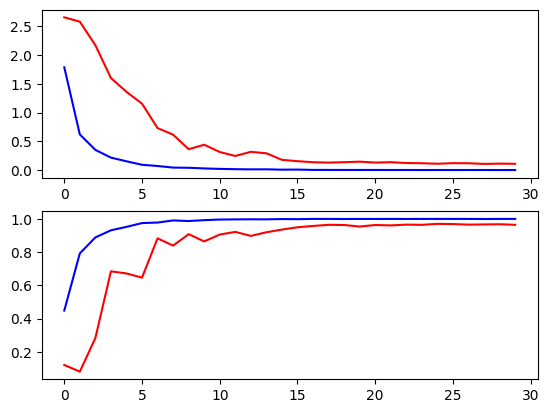

In [ ]:
f, ax = plt.subplots(2, 1)
#Assign the first subplot to graph training loss and validation loss
ax[0].plot(att_model.history.history['loss'], color = 'b', label = 'Training Loss')
ax[0].plot(att_model.history.history['val_loss'], color = 'r', label = 'Validation Loss')

#Next lets plot the training accuracy and validation accuracy
ax[1].plot(att_model.history.history['accuracy'], color = 'b', label = 'Training  Accuracy')
ax[1].plot(att_model.history.history['val_accuracy'], color = 'r', label = 'Validation Accuracy')

In [ ]:
loss, accuracy = att_model.evaluate(x_test, y_test)

print(loss, accuracy)

28/28 [==============================] - 4s 127ms/step - loss: 0.2192 - accuracy: 0.9460
0.21921780705451965 0.9460390210151672


### Model Validation

In [ ]:
pred = att_model.predict(x_test)

28/28 [==============================] - 8s 162ms/step


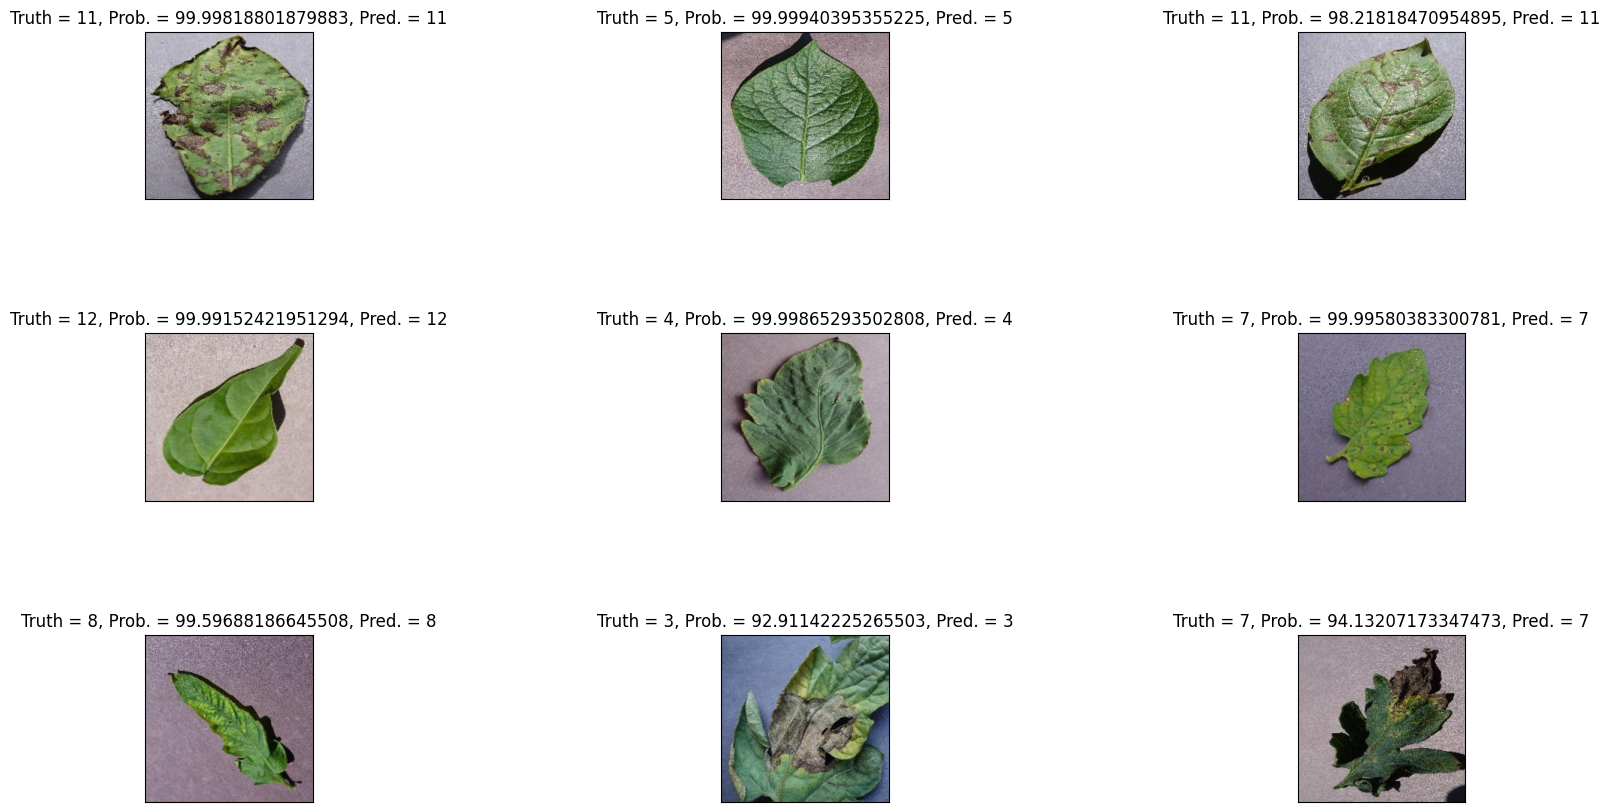

In [ ]:
plt.figure(1 , figsize = (19 , 10))
n = 0

for i in range(9):
    n += 1
    r = np.random.randint( 0, np.shape(x_test)[0], 1)

    plt.subplot(3, 3, n)
    plt.subplots_adjust(hspace = 0.8, wspace = 0.8)

    plt.imshow(x_test[r[0]])
    plt.title('Truth = {}, Prob. = {}, Pred. = {}'.format(
        np.nonzero(y_test[r[0]])[0][0],
        np.max(pred[r[0]])*100,
        np.argmax(pred[r[0]])) )
    plt.xticks([]) , plt.yticks([])

plt.show()

In [ ]:
CLASS_NAMES[np.nonzero(y_test[r[0]])[0][0]]

'Tomato__Tomato_mosaic_virus'

In [ ]:
np.argmax(att_model.predict(images))

1/1 [==============================] - 1s 926ms/step


array([[3.53281195e-07, 5.75633831e-02, 2.39308997e-06, 1.46182356e-04,
        5.09375939e-04, 3.05672927e-07, 2.27220198e-06, 9.41320837e-01,
        1.53742993e-04, 2.53534927e-06, 9.81651647e-06, 8.48182117e-06,
        7.57620242e-08, 7.61608533e-07, 2.79558153e-04],
       [2.77022906e-07, 5.19339983e-06, 2.33179804e-08, 6.92431057e-10,
        5.67931893e-05, 6.78189116e-10, 3.30092398e-08, 1.43369689e-04,
        1.01176063e-08, 2.68258820e-08, 1.02419273e-08, 2.54091237e-09,
        1.06026394e-11, 6.15302342e-09, 9.99794304e-01],
       [9.99847174e-01, 7.36759193e-06, 1.97014516e-09, 2.83969981e-09,
        1.43501486e-04, 2.14691798e-09, 4.10314227e-10, 2.18273499e-07,
        8.09392553e-11, 5.40399225e-10, 1.49132258e-12, 1.69613691e-06,
        7.34703184e-12, 1.08083442e-12, 1.08857735e-10]], dtype=float32)

In [ ]:
CLASS_NAMES

['Pepper__bell___Bacterial_spot',
 'Tomato_Early_blight',
 'Potato___Late_blight',
 'Tomato_Late_blight',
 'Tomato__Target_Spot',
 'Potato___healthy',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato_Septoria_leaf_spot',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_Leaf_Mold',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Potato___Early_blight',
 'Pepper__bell___healthy',
 'Tomato_healthy',
 'Tomato_Bacterial_spot']

## Attention Visualization

In [ ]:
!pip install keras-vis --quiet

In [ ]:
!pip install tf-keras-vis --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.1/52.1 KB 3.4 MB/s eta 0:00:00


In [ ]:
from tensorflow.keras import backend as K
from tf_keras_vis.saliency import Saliency

In [ ]:
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear

replace2linear = ReplaceToLinear()

In [ ]:
from tf_keras_vis.utils.scores import CategoricalScore

score = CategoricalScore([CLASS_LABELS[np.nonzero(y_test[r[0]])[0][0]],
                          CLASS_LABELS[np.nonzero(y_test[1+r[0]])[0][0]],
                         CLASS_LABELS[np.nonzero(y_test[2+r[0]])[0][0]]])

image_titles = [CLASS_NAMES[np.nonzero(y_test[r[0]])[0][0]],
                          CLASS_NAMES[np.nonzero(y_test[1+r[0]])[0][0]],
                         CLASS_NAMES[np.nonzero(y_test[2+r[0]])[0][0]]]

In [ ]:
image_titles

['Tomato_Septoria_leaf_spot',
 'Tomato_Bacterial_spot',
 'Pepper__bell___Bacterial_spot']

In [ ]:
score

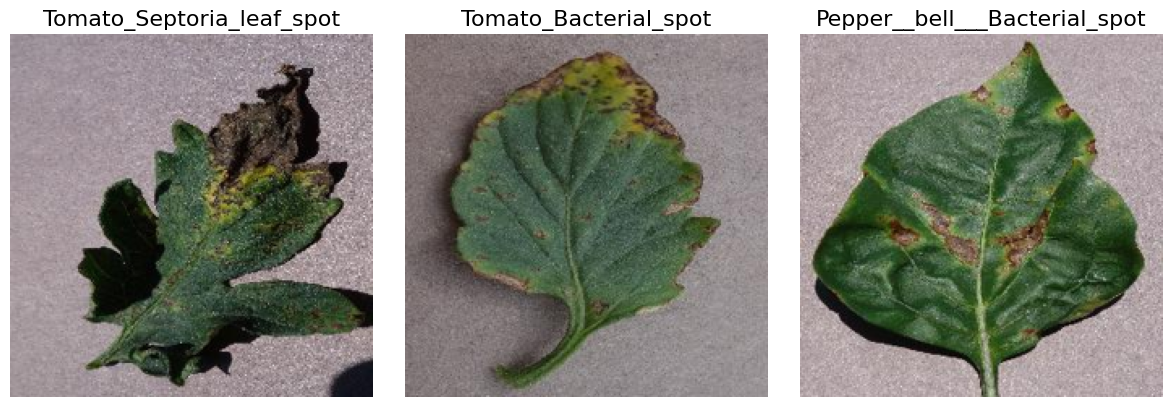

In [ ]:
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images[i], cmap='jet')
    ax[i].axis('off')
plt.tight_layout()
plt.show()

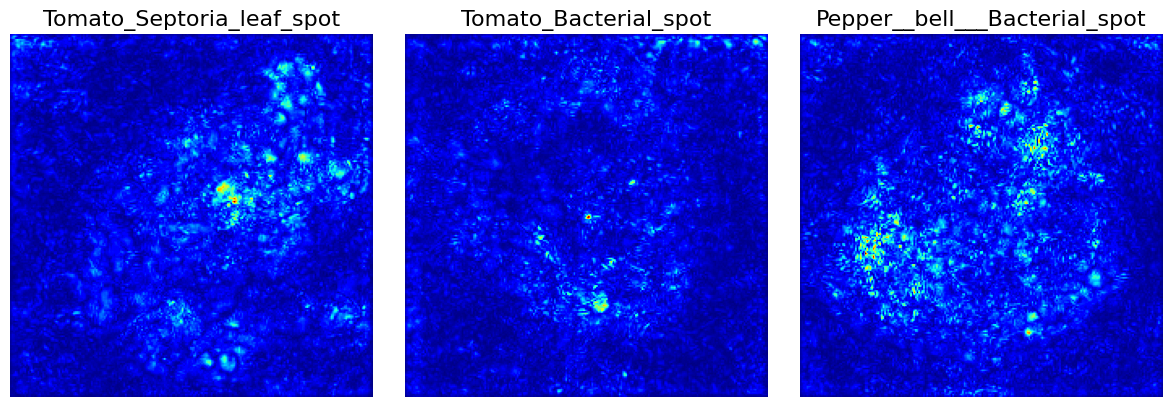

In [ ]:
# Create Saliency object.
images = np.asarray([np.array(x_test[r[0]]),
                     np.array(x_test[1+r[0]]),
                     np.array(x_test[2+r[0]])])

saliency = Saliency(att_model,
                    model_modifier=replace2linear,
                    clone=True)

# Generate saliency map
saliency_map = saliency(score, images)

## Since v0.6.0, calling `normalize()` is NOT necessary.
# saliency_map = normalize(saliency_map)

# Render
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(saliency_map[i], cmap='jet')
    ax[i].axis('off')
plt.tight_layout()
plt.show()

In [ ]:
valpath = "/content/sample_data/images/"

valtitles = ['TomatoSeptoria', 'TomatoSeptoria', 'TomatoSeptoria', 'TomatoSeptoria']

def readvalimages(valpath):
  valimg = []
  for image_name in os.listdir(valpath)[:300]:
    file_ext = image_name.split(".")[-1]
    if (file_ext.lower() == "jpg") or (file_ext.lower() == "jpeg"):
      img = cv2.imread(valpath+image_name)
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

      img_array = Image.fromarray(img, 'RGB')

      #Resizing image to 224 x 224 because the input image resolution for VGG16 is 224 x 224
      resized_img = img_array.resize((224, 224))

      valimg.append(np.array(resized_img))

  return valimg

valimg = readvalimages(valpath)
valimg = np.array(valimg).astype(np.float32)
valimg = valimg/MAXINT

In [ ]:
valtitles = ['TomatoSeptoria', 'TomatoSeptoria', 'TomatoSeptoria', 'TomatoSeptoria']

In [ ]:
np.shape(valimg)

(4, 224, 224, 3)

In [ ]:
CLASS_NAMES

['Pepper__bell___Bacterial_spot',
 'Tomato_Early_blight',
 'Potato___Late_blight',
 'Tomato_Late_blight',
 'Tomato__Target_Spot',
 'Potato___healthy',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato_Septoria_leaf_spot',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_Leaf_Mold',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Potato___Early_blight',
 'Pepper__bell___healthy',
 'Tomato_healthy',
 'Tomato_Bacterial_spot']

In [ ]:
np.argmax(att_model.predict(valimg), axis=1)

1/1 [==============================] - 0s 74ms/step


array([ 1, 14,  1,  1])

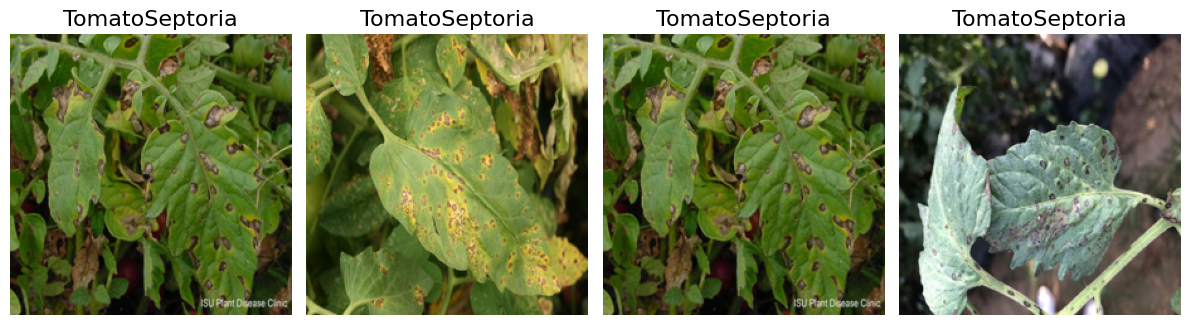

In [ ]:
f, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
for i, title in enumerate(valtitles):
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(valimg[i], cmap='jet')
    ax[i].axis('off')
plt.tight_layout()
plt.show()

In [ ]:
valscore = CategoricalScore([7, 7, 7, 7])

In [ ]:
# Generate saliency map
val_saliency_map = saliency(valscore, valimg)

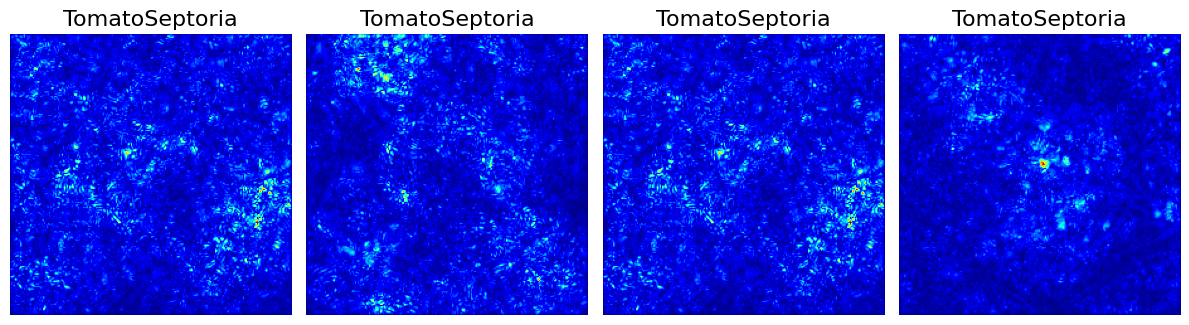

In [ ]:
# Render
f, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
for i, title in enumerate(valtitles):
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(val_saliency_map[i], cmap='jet')
    ax[i].axis('off')
plt.tight_layout()
plt.show()